# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [ ]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Python Versions
Load the basic libraries and check their versions.

In [ ]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas 1.1.2
Scikit-Learn 0.22.2.post1


# Configurations of GPU

Check GPU availability.

In [ ]:
print("GPU is", "available" if tf.test.is_gpu_available() \
      else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Enabling and Testing GPU

First, you'll need to enable GPUs for the notebook.

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Upload your Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Multiclass Classification

**Classification** is the process of predicting the class of given data points (supervised learning). 
The concept is that given a paper (abstract + title) we will try to infer the research theme of it. 

We will proceed with **Multiclass Classification**, as we now examine more than three potential classes/themes.

# Loading the Multi-Class Data Frame

* First, in jupyter notebook, we run the parser to our raw data and extract two modified csv files - one for binary classification purposes and one for multi-class classification .
* Then, we upload the files in Google Drive.
* In the code below, we select the path in *read* function to get the **mlb_clf.csv** file

In [ ]:
import numpy as np
# np.random.seed(42) # for reproducibility

# Import data
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/mlb_clf.csv")

# First, set the parameters of the notebook
pd.set_option('display.max_columns', 10) # display up to 10 columns
pd.set_option('display.max_rows', 10) # display up to 10 rows

display(df)

,label,text
0,Study,Multivariate Granger causality between CO2 emi...
1,Study,Electricity consumption-GDP nexus in Pakistan:...
2,Study,Ecological total-factor energy efficiency of r...
3,Method,Exploration and corrective measures of greenho...
4,Study,Solutions for improving the energy efficiency ...
...,...,...
820,Study,How to quantify the resolution of surface clim...
821,Study,A visual method to identify significant latitu...
822,Study,Effect of production system and farming strate...
823,Study,The effect of future climate scenarios on the ...


In [ ]:
# Getting some information about our data (EDA was performed to the 'parser_eda_extract.ipynb')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   825 non-null    object
 1   text    825 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


In [ ]:
# Getting the input and output data
texts = df['text']
themes = df['label']

In [ ]:
# Counting the frequency of each label
from collections import Counter

theme_counts = Counter(themes)
theme_counts.most_common()

[('Study', 628),
 ('Method', 74),
 ('Review', 29),
 ('Interview', 25),
 ('Policy', 19),
 ('Tool', 11),
 ('Prototype', 9),
 ('Treatment', 9),
 ('Evaluation', 6),
 ('Diagnostic Tool', 4),
 ('Other', 3),
 ('Clinical Trial', 3),
 ('Diagnositc Tool', 2),
 ('Search', 1),
 ('Device', 1),
 ('Infrastructure', 1)]

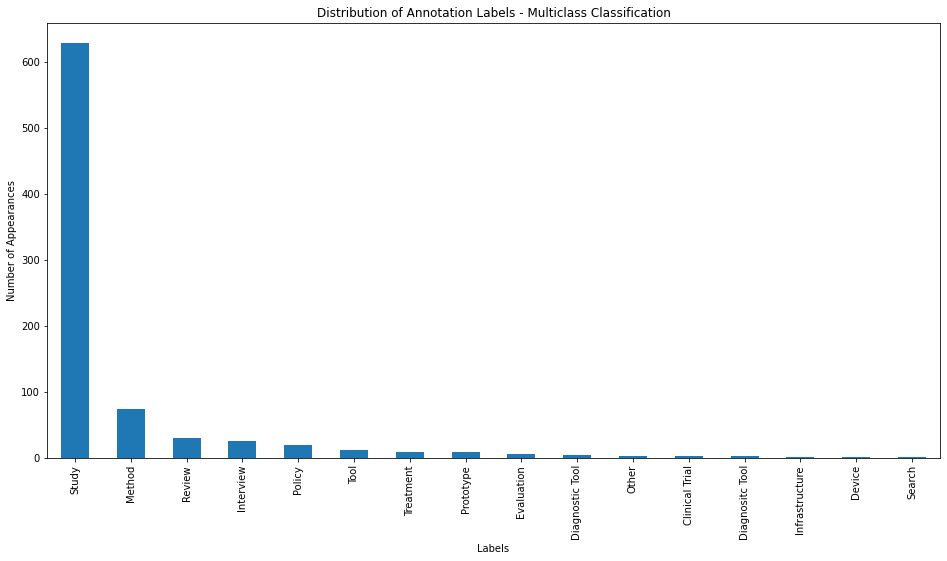

In [ ]:
# Visualize the labels' frequency by creating a histogram plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16, 8))
plt.title("Distribution of Annotation Labels - Multiclass Classification")
plt.xlabel('Labels')
plt.ylabel('Number of Appearances')

df['label'].value_counts().plot(kind='bar')

Obviously our dataset is highly unbalanced.
In this case, random sampling is a very bad option for splitting. 

We reach the conclusion that we have to use stratified sampling in order to split the class proportionally between training and test set.

The next step is to select the most common labels for the classification. By evaluating the results, we decide to include the top-9 labels which have at least 9 counts. 

We took into consideration that, during the annotation process, it was obligatory that each paper could have only one research theme.

In [ ]:
# Extract the top 9 labels
top_labels = theme_counts.most_common()[:9] # list of tuples

convert_to_list = [item for t in top_labels for item in t]

# Convert to list of strings
top_labels = [lbl for lbl in convert_to_list if isinstance(lbl, str)]
print(top_labels)

['Study', 'Method', 'Review', 'Interview', 'Policy', 'Tool', 'Prototype', 'Treatment', 'Evaluation']


In [ ]:
# Keep only the texts that are in the given List of top labels
df_top_labels = df[df['label'].isin(top_labels)].reset_index(drop=True)
display(df_top_labels.sample(10))

,label,text
731,Study,"Frederick T. Short, Hilary A. Neckles, The eff..."
31,Method,LCA of a solar heating and cooling system equi...
545,Study,Suicide in Serbia. BACKGROUND: Suicide remains...
437,Study,Demographic and regional characteristics of ro...
458,Study,An analysis of the characteristics of road tra...
274,Study,﻿Thirty-year trends in the prevalence and seve...
116,Study,"The nexus between urbanization, renewable ener..."
462,Study,[Suicide mortality: gender and socioeconomic d...
496,Study,Mortality among recent purchasers of handguns ...
439,Study,Estimating deaths and injuries due to road tra...


In [ ]:
# we check again the size of our dataset
df_top_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   810 non-null    object
 1   text    810 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


We observe that now our dataset consists of 810 papers of text.

In [ ]:
# Getting the input and output data
texts = df_top_labels['text']
themes = df_top_labels['label']

We have to convert the categorical text output data into model-understandable numerical data.

**Label Encoder** is part of the SciKit Learn library and it is used to convert categorical data, or text data, into numbers, which our predictive models can better understand.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(themes)

In [ ]:
# Overview of input data
display(texts)

0      Multivariate Granger causality between CO2 emi...
1      Electricity consumption-GDP nexus in Pakistan:...
2      Ecological total-factor energy efficiency of r...
3      Exploration and corrective measures of greenho...
4      Solutions for improving the energy efficiency ...
                             ...                        
805    How to quantify the resolution of surface clim...
806    A visual method to identify significant latitu...
807    Effect of production system and farming strate...
808    The effect of future climate scenarios on the ...
809    Comparing environmental impacts of beef produc...
Name: text, Length: 810, dtype: object

In [ ]:
# Overview of output data
display(labels[:20])

array([6, 6, 6, 2, 6, 6, 6, 3, 6, 6, 2, 6, 6, 6, 3, 2, 2, 2, 6, 6])

In [ ]:
# Sanity check between texts and labels
print(len(texts) == len(labels))

True


# Preprocessing the dataset

The papers that comprise our dataset, originate from an annotation tool - [link here](https://inventory.clarin.gr/) . 

This means that most of heavy preprocessing such as
- special characters,
- tags, html\code\xml etc. ,

was conducted by the annotation tool during upload. 
Even so we continue with the following preprocess methods, so as to better modify our dataset for the text classification that takes place later on this notebook.

In [ ]:
import re

class annotation_preprocess:

    @staticmethod
    def remove_underscores(sentence):
        return re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    
    @staticmethod
    def remove_multiple_spaces(sentence):
        return re.sub(r' +', ' ', sentence)

    @staticmethod
    def remove_trailing_spaces(sentence):
        return sentence.strip()
    
def annotation_preprocess_row(row):
    row = annotation_preprocess.remove_underscores(row)
    row = annotation_preprocess.remove_multiple_spaces(row)
    row = annotation_preprocess.remove_trailing_spaces(row)
    row = row.lower()
    return row

Static methods, much like class methods, are methods that are bound to a class rather than its object.

They do not require a class instance creation. So, they are not dependent on the state of the object.

The difference between a static method and a class method is:

* Static method knows nothing about the class and just deals with the parameters.
* Class method works with the class since its parameter is always the class itself.

In [ ]:
# Apply to the input data and display the results
texts = texts.apply(lambda row: annotation_preprocess_row(row))
display(texts)

0      multivariate granger causality between co2 emi...
1      electricity consumption-gdp nexus in pakistan:...
2      ecological total-factor energy efficiency of r...
3      exploration and corrective measures of greenho...
4      solutions for improving the energy efficiency ...
                             ...                        
805    how to quantify the resolution of surface clim...
806    a visual method to identify significant latitu...
807    effect of production system and farming strate...
808    the effect of future climate scenarios on the ...
809    comparing environmental impacts of beef produc...
Name: text, Length: 810, dtype: object

# Word Embeddings

You cannot feed raw text directly into deep learning models. Text data must be encoded as numbers to be used as input or output for machine learning and deep learning models. Words are called tokens and the process of splitting text into tokens is called **Tokenization**.

A **Word Embedding** is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding.

For this deep learning project we will use 2 methods of learning word embeddings:
- GloVe
- Self-learned as part of a deep learning model

# Tokenizing input text data using Self-trained Word Embeddings

We set some hyperparameters for performing tokenization and preparing the standardized data representation, with explanations below (comments).

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# maximum number of words from our resulting tokenized data vocabulary,
# which are to be used, truncated after the 5000 most common words in our case. 
max_words = 5000

# Creates a tokenizer, configured to only take into account the 5000 most common words
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

Regarding **oov_token**:
This is the token which will be used for tokens encountered during the tokenizing and encoding of test data sequences

Keras lets us define an **Out Of Vocab** token **(OOV)** - this will replace any unknown words with a token of our choosing. This is better than just throwing away unknown words since it tells our model there was information here.

In [ ]:
samples = texts.tolist()

# Build the word index
# Generate tokens by counting frequency
tokenizer.fit_on_texts(samples)

In [ ]:
# Turns strings into lists of integer indices, specifically, sequence of numbers
sequences = tokenizer.texts_to_sequences(samples)

# Get max/min text sequence length
seqmax = max([len(x) for x in sequences])
seqmin = min([len(x) for x in sequences])

print("Maximum sequence length is:", seqmax)
print()
print("Minimum sequence length is:", seqmin)

Maximum sequence length is: 811

Minimum sequence length is: 105


Quick explanation on some tokenizer functions:

- **word index:** dictionary that maps each word to a number (dictionary of words and their indices)
- **word_counts:** dictionary of words and the number of times they have appeared in text
- **word_docs:** dictionary of words and the number of documents the appeared in
- **document_count:** total number of documents



At the end you can see that words that are frequently used in discussions about *Sustainable Development Goals* have a lower token number.

In [ ]:
print('Word Index')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(type(word_index))

print()
print('Word Counts')
print(tokenizer.word_counts)

print()
print('Word Docs')
print(tokenizer.word_docs)

print()
print('Document Count')
print(tokenizer.document_count)

print()
print('Some examples')
print('Token for the word "energy": {}'.format(word_index['energy']))
print('Token for the word "source": {}'.format(word_index['source']))
print('Token for the word "game": {}'.format(word_index['game']))
print()
print('We notice that the word "game" is rarely used in discussions concerning SDGs.')

Word Index
Found 13183 unique tokens.
<class 'dict'>

Word Counts
OrderedDict([('multivariate', 30), ('granger', 8), ('causality', 30), ('between', 631), ('co2', 84), ('emissions', 292), ('energy', 795), ('consumption', 201), ('fdi', 8), ('foreign', 29), ('direct', 68), ('investment', 52), ('and', 8837), ('gdp', 60), ('gross', 20), ('domestic', 135), ('product', 26), ('evidence', 204), ('from', 1202), ('a', 2982), ('panel', 38), ('of', 8463), ('bric', 2), ('brazil', 23), ('russian', 2), ('federation', 3), ('india', 75), ('china', 143), ('countries', 440), ('abstract', 396), ('this', 1148), ('paper', 183), ('addresses', 8), ('the', 10840), ('impact', 275), ('both', 264), ('economic', 241), ('growth', 130), ('financial', 51), ('development', 274), ('on', 1447), ('environmental', 316), ('degradation', 23), ('using', 400), ('cointegration', 13), ('technique', 26), ('for', 2327), ('period', 186), ('1980', 13), ('2007', 45), ('except', 21), ('russia', 3), ('1992–2007', 1), ('in', 5624), ('lo

We proceed with Keras **padding**, to make sure that all text sequences we feed into the model have the same length. 

When we are encoding our numeric sequence representations of the text data, our sentences lengths will not be uniform, and so we will need to select a maximum length for sentences and pad unused sentence positions in shorter sentences with a padding character. On the contrary, longer sequences are truncated so that they fit the desired length.

With **pad_sequences** by default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence. By default truncating is also set to **"pre"** , which truncates the beginning part of the sequence

Whether we pre-pad or post-pad sentences is our decision to make, and we have selected **"post"**, meaning that our sentence sequence numeric representations corresponding to word index entries will appear at the left-most positions of our resulting sentence vectors, while the padding characters ('0') will appear after our actual data at the right-most positions of our resulting sentence vectors.

In [ ]:
# number of words, cut of text after 200 words
maxlen = 200 
pad_type = 'post'

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
data = pad_sequences(sequences, padding = pad_type, maxlen=maxlen)

print("Padded training sequences:\n", data)
print()
print('-' * 50)
print()
print("Padded training shape:", data.shape)

Padded training sequences:
 [[   1 4949  428 ... 1095    1   45]
 [ 195  144  550 ...    0    0    0]
 [1394   20 3069 ...   13    2 3070]
 ...
 [  88   33  315 ... 1593   36 2319]
 [  17   22  347 ...  220    4  446]
 [1356    3  601 ... 1702  606  484]]

--------------------------------------------------

Padded training shape: (810, 200)


# Splitting/Shuffling Dataset Procedure
Following code performs, data splitting in train-validation datasets,  knowning that we are dealing with an imbalanced dataset.

As mentioned before, we should split the raw dataset in Train - Test in a stratified manner in order to prevent the distribution of the training data to bias our model accordingly to it.

We choose to split the data according to Pareto principle (80/20 is the common occurring ratio).
- Training dataset
- Test/Validation dataset (unseen data)

In [ ]:
# The raw input (abstracts)
x = data

# The raw output (binary research themes)
y = labels

In [ ]:
# We will use this object to split the raw dataset in Train - Test in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [ ]:
# splitting in train-val and test
x_train, x_val, y_train, y_val = None, None, None, None

# getting the indexes for each dataset
for train_index, val_index in test_sss.split(x, y):
    
    print("TRAIN:", train_index[:10], "VALID:", val_index[:10])
    
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

TRAIN: [590 751  53 488 363 644  79 527 786 355] VALID: [316 696 660 797 597 307 315  73 199 439]
TRAIN: [226 779 366 587 619 805 351 595  50 378] VALID: [ 25 557 562 636 131 246 670 480 476 356]
TRAIN: [243 140 495 307 218  37 182 385  58 548] VALID: [ 29  35 566 444   0 337 200 430 328 179]
TRAIN: [382 414 265 709 254 180 595 161 378 489] VALID: [231  85 676 117 293 463 383 428 391 236]
TRAIN: [484 788  16 453 731 539 522 327 636 630] VALID: [289 209 786 605 661 544 238 809 704 338]


# Labels Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

print('Convert Themes (class vector) to binary class matrix (for use with categorical_crossentropy)')
# to_categorical() function converts the labels to one_hot_encoding
y_train = to_categorical(y_train, len(themes.value_counts()))
y_val = to_categorical(y_val, len(themes.value_counts()))

Convert Themes (class vector) to binary class matrix (for use with categorical_crossentropy)


In [ ]:
# Datasets' size & shape after splitting
print("Initial Dataset size:", len(df)) 
print("Training Dataset size:", len(x_train)) 
print("Test/Validation Dataset size:", len(x_val)) 
print()
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()
print('x_val shape: {}'.format(x_val.shape))
print('y_val shape: {}'.format(y_val.shape))

Initial Dataset size: 825
Training Dataset size: 648
Test/Validation Dataset size: 162

x_train shape: (648, 200)
y_train shape: (648, 9)

x_val shape: (162, 200)
y_val shape: (162, 9)


# Pre-trained GloVe Embeddings

Since you are executing below UNIX commands during Colab session, the files will be available only for the running session. In case you want to re-run any steps, do not execute those commands again (better to comment them out).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-20 13:36:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-20 13:36:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-20 13:36:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from tqdm import tqdm

def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname)  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [ ]:
pre_embedding_dim = 100  # We now use larger embeddings

embeddings_index = load_glove_embeddings(dim=pre_embedding_dim)

Loading Embeddings: 6346word [00:00, 32678.95word/s]

Loading word vectors


Loading Embeddings: 400000word [00:13, 30276.22word/s]

Found 400000 word vectors.


In [ ]:
embeddings_index['energy']

array([ 0.014314 ,  0.68838  ,  1.0354   , -0.22272  ,  0.7122   ,
       -1.8591   , -0.54074  ,  0.3788   , -0.4473   ,  0.39239  ,
        0.015253 , -0.91126  , -0.75051  , -0.20166  , -0.38735  ,
       -0.76363  , -0.30962  ,  0.46411  ,  0.086319 , -0.48519  ,
       -0.23435  , -0.47433  , -0.0079533, -0.11603  , -0.51613  ,
        0.903    , -0.089598 ,  0.57729  , -0.22603  ,  0.72144  ,
       -0.25002  ,  0.1062   , -0.94918  , -0.084096 , -0.62692  ,
       -0.17111  ,  0.1704   ,  0.38448  ,  0.039208 , -0.12554  ,
        0.17141  , -1.1132   , -0.5683   , -0.093456 , -0.028492 ,
       -0.01072  , -0.58381  ,  0.46759  , -0.15049  , -0.59781  ,
        0.18358  , -0.11986  ,  0.14094  ,  1.0061   ,  0.35668  ,
       -2.1176   , -0.11615  ,  0.14937  ,  1.6014   ,  0.3073   ,
        0.68025  , -0.69607  , -0.69121  , -0.23822  ,  1.0161   ,
        0.46592  ,  0.5549   , -0.12957  ,  1.3661   , -0.39927  ,
        0.70148  , -0.023808 ,  0.42136  , -0.4654   ,  0.1101

In [ ]:
embeddings_index['energy'].shape

(100,)

Not all words that are in our **annotation** vocabulary might be in the GloVe embedding though. For missing words it is wise to use random embeddings with the same mean and standard deviation as the GloVe embeddings.

In [ ]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [ ]:
embedding_matrix = create_embeddings_matrix(
    emb_index=embeddings_index, 
    tokenizer=tokenizer, 
    emb_dim=pre_embedding_dim
    )

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: 0.004451991990208626 | STD: 0.4081574082374573
Found 4857 pre-trained embeddings out of 5000


This embedding matrix is used as weights for the embedding layer. This way, the embedding layer uses the pre-trained GloVe weights instead of random ones.

We can also set the embedding layer to NOT trainable. This means, Keras won't change the weights of the embeddings while training which makes sense since our embeddings are already trained.

# Multi-Layer Perceptron Neural Network
Multi-Layer Perceptrons, or MLPs for short, are the classical type of neural network. 

They are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer.

# Convolutional Neural Network
Convolutional Neural Networks, or CNNs, were designed to map image data to an output variable. They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks.

The benefit of using CNNs is their ability to develop an internal representation of a two-dimensional image. This allows the model to learn position and scale in variant structures in the data, which is important when working with images.

More generally, CNNs work well with data that has a spatial relationship. The CNN input is traditionally two-dimensional, a field or matrix, but can also be changed to be one-dimensional, allowing it to develop an internal representation of a one-dimensional sequence.

This allows the CNN to be used more generally on other types of data that has a spatial relationship. For example, there is an order relationship between words in a document of text. 

## Regarding CNNs' Layers
A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

# Import Libraries

In [ ]:
from itertools import cycle
from scipy import interp
from keras import backend as K

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model
from pprint import pprint

from typing import List, Tuple
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Variations - Hyperparameter Tuning

## Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data with either approaches:
- Learning an Embedding
- Using Pre-Trained GloVe Embedding

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step was performed using the Tokenizer API also provided with Keras. 
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- **input_dim:** This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- **output_dim:** This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger.
- **input_length:** This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

## Dropout Regularization
Dropout Regularization is a computationally cheap way to regularize a deep neural network.
Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structure and, in turn, making nodes in the network generally more robust to the inputs. 

Dropout value needs finetuning because a probability too low has minimal effect and a value too high results in under-learning by the network. Dropout can be used on visible as well as hidden units. Application of dropout at each layer of the network has shown good results.

## Batch Normalization
Batch Normalization is just another layer, so you can use it as such to create your desired network architecture. It is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network.

The general use case is to use BN between the linear and non-linear layers in your network, because it normalizes the input to your activation function, so that you're centered in the linear section of the activation function (such as Sigmoid) . It applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 

Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural network, and in some cases improves the performance of the model via a modest regularization effect.

## Activation Functions
Activation functions, in layman's terms, are a choice that you must make for each layer:
- **relu:** Very popular neural network activation function. Used for hidden layers, cannot output negative values. No trainable parameters
- **softmax:** Used for multi-class classification. Ensures all output neurons behave as probabilities and sum to 1 .

## Loss functions
### CategoricalCrossentropy
Computes the crossentropy loss between the labels and predictions. 
We expect labels to be provided in a one_hot representation.

## Keras Callbacks

### Model Checkpoint
Save the current weights of the model at different points
during training.

### Early Stopping
Interrupt training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs.

### ReduceLROnPlateau
Reduce learning rate when a metric has stopped improving.

## Configuration of the Model
The model that we will create is a sequential model meaning that each layer that we add per line will use as input the output of the former layer added to the model. We have to specify:

- **embedding_dim:** how large we want the word vectors to be. A 50 dimensional vector is able to capture good embeddings even for quite large vocabularies
- **max_words:** for how many words we want embeddings
- **maxlen:** how long our sequences are

### Training Parameter
Regarding **batch size** and **epochs**, both are integer values:

- The batch size is a hyperparameter that controls the number of training samples to work through before the model’s internal parameters are updated.
- The number of epochs is a hyperparameter that controls the number of complete passes through the training dataset

### Neurons and Layers
Usually it is not a good idea to use less neurons on intermediate layers. Small layers may act as information bottlenecks, permanently dropping relevant information.

In [ ]:
def add_space():
  print() 
  print("-" * 50) 
  print()

In [ ]:
n_classes = len(themes.value_counts())
print("Number of Classes: ", n_classes)
add_space()
print("For how many words we want embeddings: ", max_words)
add_space()
print("How long our sequences are: ", maxlen)
add_space()

# Smaller Embeddings than Pre-trained Models
self_embedding_dim  = 50
print("Size of word vectors: ", self_embedding_dim)

Number of Classes:  9

--------------------------------------------------

For how many words we want embeddings:  5000

--------------------------------------------------

How long our sequences are:  200

--------------------------------------------------

Size of word vectors:  50


In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

In [ ]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


# MLP - Self-trained Embeddings


--------------------------------------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           250000    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
den

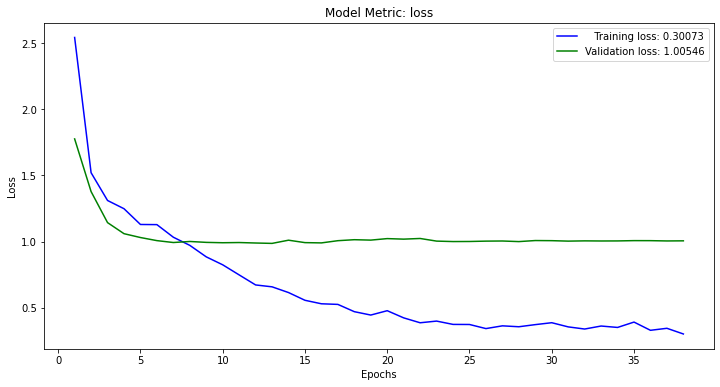

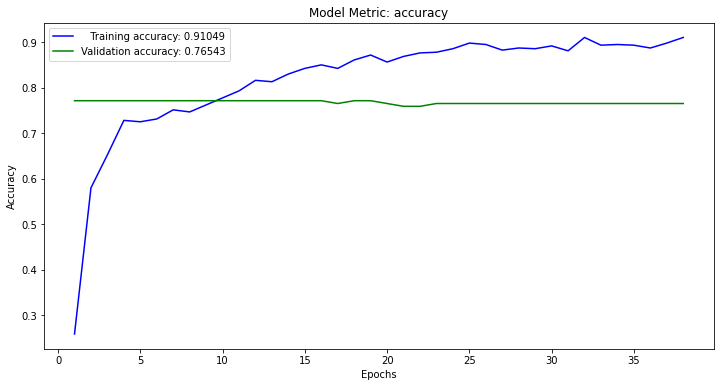

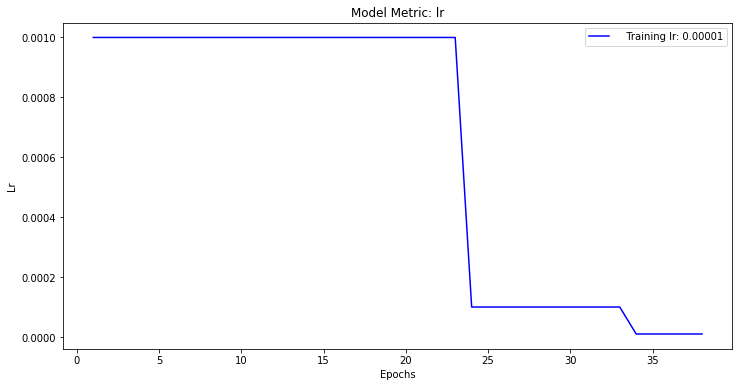

6/6 [==============================] - 0s 4ms/step - loss: 0.9861 - accuracy: 0.7716

--------------------------------------------------


Categorical Crossentropy for model: 98.610 %

Accuracy for model: 77.160 %

--------------------------------------------------


--------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


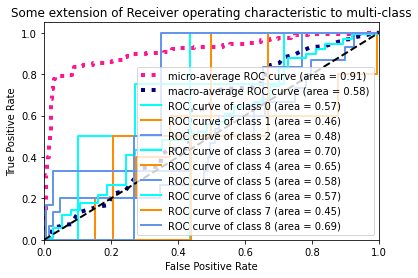

In [ ]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_mlp_adap_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
selfembed_mlp_adam_model = Sequential()

# Self-Embedding Layer
selfembed_mlp_adam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_mlp_adam_model.add(Flatten())

# Input layer
selfembed_mlp_adam_model.add(Dense(64, input_dim=x_train.shape[1]))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(Dropout(0.5))

# Hidden layer    
selfembed_mlp_adam_model.add(Dense(128))
selfembed_mlp_adam_model.add(BatchNormalization())
selfembed_mlp_adam_model.add(Activation('relu'))
selfembed_mlp_adam_model.add(Dropout(0.5))

# Output Layer
selfembed_mlp_adam_model.add(Dropout(0.5))
selfembed_mlp_adam_model.add(Dense(n_classes,  activation = 'softmax'))

add_space()
selfembed_mlp_adam_model.summary()

add_space()
plot_model(
    selfembed_mlp_adam_model, 
    to_file='selfembed_mlp_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
selfembed_mlp_adam_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_mlp_adam_model = selfembed_mlp_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val),
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_mlp_adam_model.history)

add_space()
plot_keras_history(history_selfembed_mlp_adam_model)

# Model Evaluation
score_selfembed_mlp_adam_model = selfembed_mlp_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nCategorical Crossentropy for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_mlp_adam_model[1]*100))


add_space()
# Model Prediction
pred_keras_selfembed_mlp_adam_model = selfembed_mlp_adam_model.predict(x_val)

add_space()
plot_multi_class_roc_auc_curves(
    nb_classes=n_classes, 
    y_true=y_val, 
    y_pred_score=pred_keras_selfembed_mlp_adam_model
    )

# MLP - Pre-trained GloVe Embeddings


--------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2560128   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
d

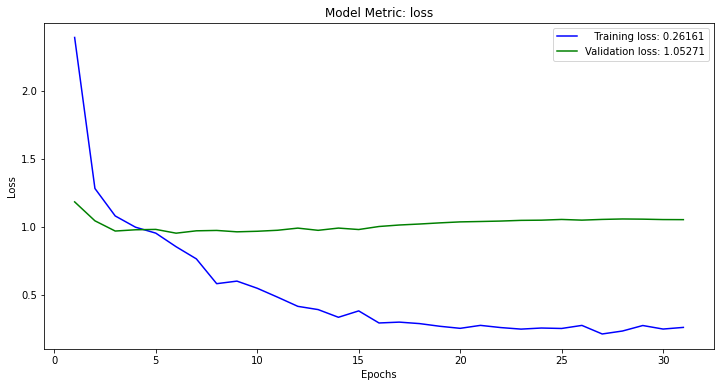

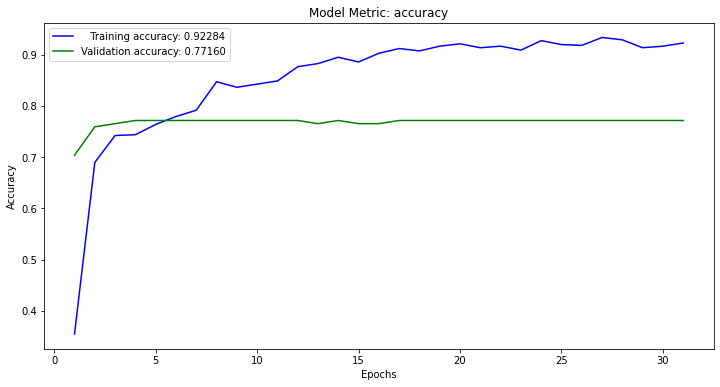

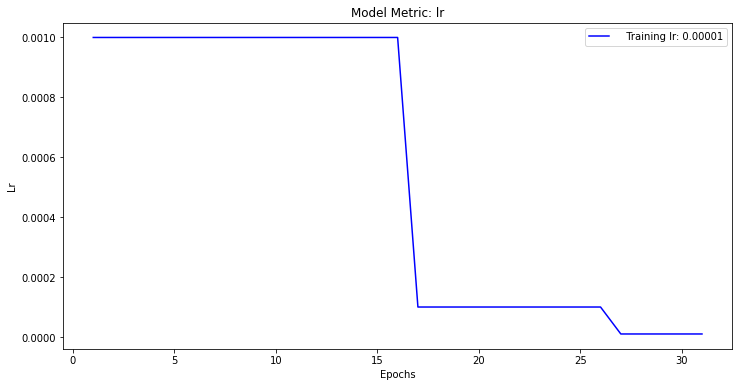

6/6 [==============================] - 0s 4ms/step - loss: 0.9534 - accuracy: 0.7716

--------------------------------------------------


Categorical Crossentropy for model: 95.341 %

Accuracy for model: 77.160 %

--------------------------------------------------


--------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


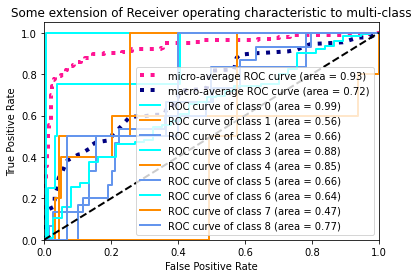

In [ ]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrained_mlp_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model

# define an empty sequential structure
pretrained_mlp_adam_model = Sequential()

# Pre-Trained Embedding Layer
pretrained_mlp_adam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrained_mlp_adam_model.add(Flatten())

# Input layer
pretrained_mlp_adam_model.add(Dense(128, input_dim=x_train.shape[1]))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Hidden layer    
pretrained_mlp_adam_model.add(Dense(256))
pretrained_mlp_adam_model.add(BatchNormalization())
pretrained_mlp_adam_model.add(Activation('relu'))
pretrained_mlp_adam_model.add(Dropout(0.5))

# Output Layer
pretrained_mlp_adam_model.add(Dropout(0.5))
pretrained_mlp_adam_model.add(Dense(n_classes,  activation = 'softmax'))

add_space()
pretrained_mlp_adam_model.summary()

add_space()
plot_model(
    pretrained_mlp_adam_model, 
    to_file='pretrained_mlp_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
pretrained_mlp_adam_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrained_mlp_adam_model = pretrained_mlp_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val),
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrained_mlp_adam_model.history)

add_space()
plot_keras_history(history_pretrained_mlp_adam_model)

# Model Evaluation
score_pretrained_mlp_adam_model = pretrained_mlp_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nCategorical Crossentropy for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrained_mlp_adam_model[1]*100))


add_space()
# Model Prediction
pred_keras_pretrained_mlp_adam_model = pretrained_mlp_adam_model.predict(x_val)

add_space()
plot_multi_class_roc_auc_curves(
    nb_classes=n_classes, 
    y_true=y_val, 
    y_pred_score=pred_keras_pretrained_mlp_adam_model
    )

# CNN - Self-trained Embeddings


--------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           250000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 32)           4832      
_________________________________________________________________
batch_normalization_4 (Batch (None, 198, 32)           128       
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
b

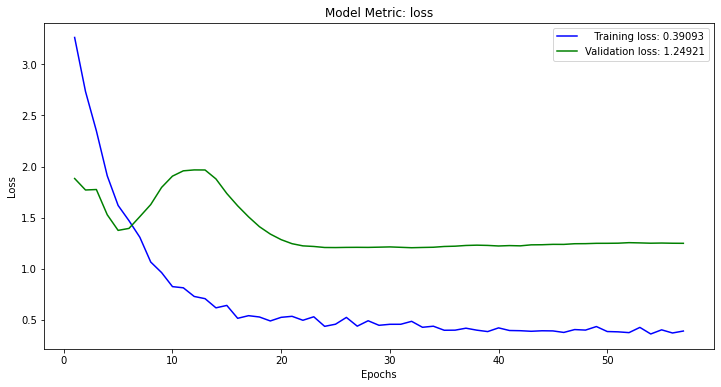

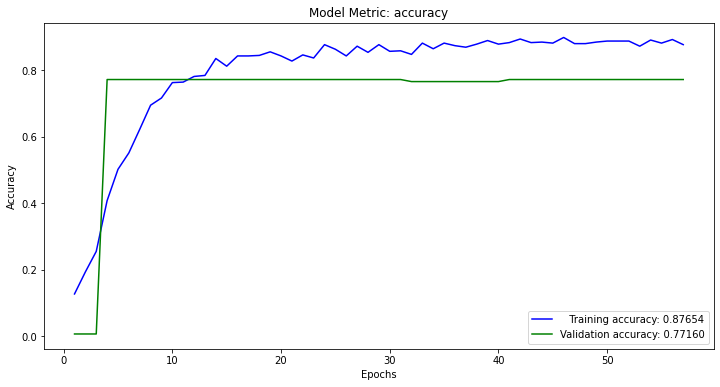

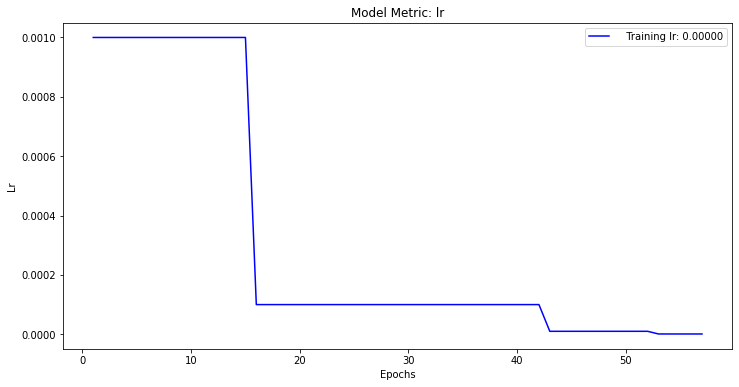

6/6 [==============================] - 0s 4ms/step - loss: 1.2061 - accuracy: 0.7654

--------------------------------------------------


Categorical Crossentropy for model: 120.609 %

Accuracy for model: 76.543 %

--------------------------------------------------


--------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


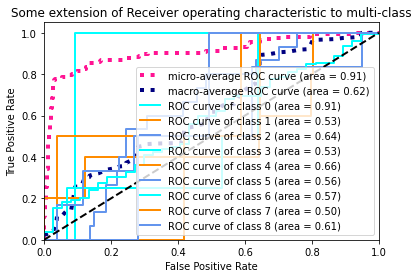

In [ ]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='selfembed_cnn_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model
# Create a Baseline Neural Network

selfembed_cnn_adam_model = Sequential()

# Embedding layer
selfembed_cnn_adam_model.add(Embedding( 
    input_dim = max_words, 
    output_dim = self_embedding_dim , 
    embeddings_initializer = 'uniform', 
    trainable = True,
    mask_zero = True, 
    input_length = maxlen
    )
)

selfembed_cnn_adam_model.add(Conv1D(32, 3, padding='valid', activation='relu', strides=1))
selfembed_cnn_adam_model.add(BatchNormalization())
selfembed_cnn_adam_model.add(GlobalMaxPooling1D())

selfembed_cnn_adam_model.add(Flatten())

selfembed_cnn_adam_model.add(Dense(64))
selfembed_cnn_adam_model.add(BatchNormalization())
selfembed_cnn_adam_model.add(Activation('relu'))
selfembed_cnn_adam_model.add(Dropout(0.5))

selfembed_cnn_adam_model.add(BatchNormalization())
selfembed_cnn_adam_model.add(Dropout(0.5))
selfembed_cnn_adam_model.add(Dense(n_classes,  activation = 'softmax'))

add_space()
selfembed_cnn_adam_model.summary()

add_space()
plot_model(
    selfembed_cnn_adam_model, 
    to_file='selfembed_cnn_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
selfembed_cnn_adam_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
    )

add_space()
print('Fitting Model..')
# Model Fit
history_selfembed_cnn_adam_model = selfembed_cnn_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val),
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_selfembed_cnn_adam_model.history)

add_space()
plot_keras_history(history_selfembed_cnn_adam_model)

# Model Evaluation
score_selfembed_cnn_adam_model = selfembed_cnn_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nCategorical Crossentropy for model: {:.3f} %'.format(score_selfembed_cnn_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_selfembed_cnn_adam_model[1]*100))


add_space()
# Model Prediction
pred_keras_selfembed_cnn_adam_model = selfembed_cnn_adam_model.predict(x_val)

add_space()
plot_multi_class_roc_auc_curves(
    nb_classes=n_classes, 
    y_true=y_val, 
    y_pred_score=pred_keras_selfembed_cnn_adam_model
    )

# CNN - Pre-trained GloVe Embeddings


--------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
batch_normalization_7 (Batch (None, 198, 128)          512       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
b

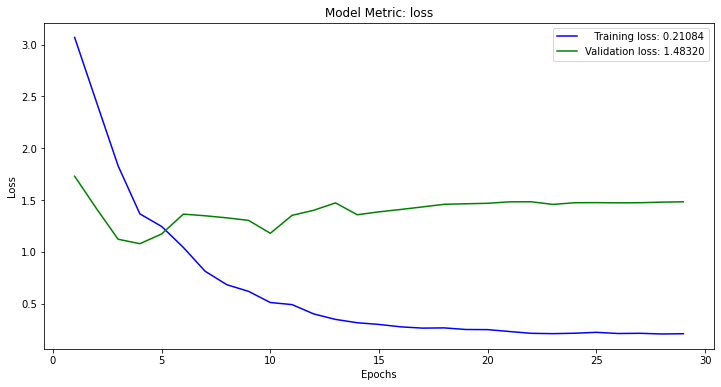

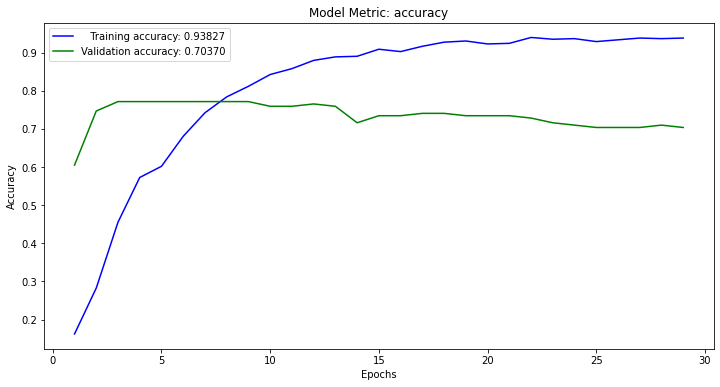

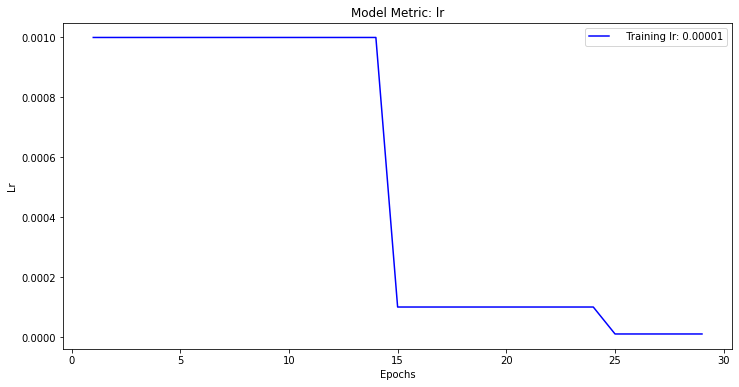

6/6 [==============================] - 0s 4ms/step - loss: 1.0792 - accuracy: 0.7716

--------------------------------------------------


Categorical Crossentropy for model: 107.920 %

Accuracy for model: 77.160 %

--------------------------------------------------


--------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


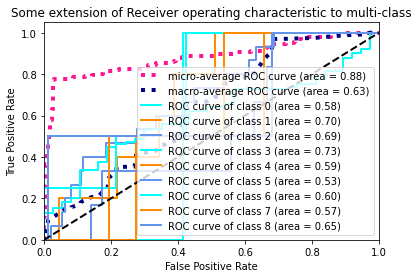

In [ ]:
# Define Keras Callbacks

keras_callbacks = [ 
             EarlyStopping( 
                 monitor = 'val_loss', 
                 min_delta = 0.0001,
                 mode='min',
                 patience = 25, 
                 restore_best_weights = True,
                 verbose = 1, 
                 ), 

             ModelCheckpoint( 
                 filepath='pretrainedembed_cnn_adam_h5', 
                 monitor='val_loss', 
                 mode='min',
                 save_best_only = True, 
                 save_weights_only = False,
                 verbose = 1 
                 ), 

             ReduceLROnPlateau( 
                 monitor = 'val_loss', 
                 factor = 0.1, 
                 patience = 10, 
                 verbose = 1 
                 ) 
             ]

# Define The Neural Network Model
# Create a Baseline Neural Network

pretrainedembed_cnn_adam_model = Sequential()

# Pre-Trained Embedding Layer
pretrainedembed_cnn_adam_model.add(Embedding(
    input_dim = max_words, 
    output_dim = pre_embedding_dim , 
    input_length = maxlen, 
    weights=[embedding_matrix], 
    trainable = False
    )
)

pretrainedembed_cnn_adam_model.add(Conv1D(128, 3, padding='valid', activation='relu', strides=1))
pretrainedembed_cnn_adam_model.add(BatchNormalization())
pretrainedembed_cnn_adam_model.add(GlobalMaxPooling1D())

pretrainedembed_cnn_adam_model.add(Flatten())

pretrainedembed_cnn_adam_model.add(Dense(256))
pretrainedembed_cnn_adam_model.add(BatchNormalization())
pretrainedembed_cnn_adam_model.add(Activation('relu'))
pretrainedembed_cnn_adam_model.add(Dropout(0.5))

pretrainedembed_cnn_adam_model.add(BatchNormalization())
pretrainedembed_cnn_adam_model.add(Dropout(0.5))
pretrainedembed_cnn_adam_model.add(Dense(n_classes,  activation = 'softmax'))

add_space()
pretrainedembed_cnn_adam_model.summary()

add_space()
plot_model(
    pretrainedembed_cnn_adam_model, 
    to_file='pretrainedembed_cnn_adam_model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
    )

add_space()
print('Compiling Model..')

# Compile model
pretrainedembed_cnn_adam_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
    )

add_space()
print('Fitting Model..')
# Model Fit
history_pretrainedembed_cnn_adam_model = pretrainedembed_cnn_adam_model.fit(
    x_train, y_train, 
    epochs=250, batch_size=16, 
    validation_data=(x_val, y_val),
    verbose = 1, callbacks= keras_callbacks, shuffle = True 
    )

add_space()
pprint(history_pretrainedembed_cnn_adam_model.history)

add_space()
plot_keras_history(history_pretrainedembed_cnn_adam_model)

# Model Evaluation
score_pretrainedembed_cnn_adam_model = pretrainedembed_cnn_adam_model.evaluate( 
    x_val, y_val, 
    batch_size=32, 
    verbose=1
    )

add_space()
print('\nCategorical Crossentropy for model: {:.3f} %'.format(score_pretrainedembed_cnn_adam_model[0]*100))
print('\nAccuracy for model: {:.3f} %'.format(score_pretrainedembed_cnn_adam_model[1]*100))


add_space()
# Model Prediction
pred_keras_pretrainedembed_cnn_adam_model = pretrainedembed_cnn_adam_model.predict(x_val)

add_space()
plot_multi_class_roc_auc_curves(
    nb_classes=n_classes, 
    y_true=y_val, 
    y_pred_score=pred_keras_pretrainedembed_cnn_adam_model
    )